## Benchmark: ARIMA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MSE, MAE, MAPE

%matplotlib inline
import os
import sys
import platform
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data, get_fx_and_metric_data_wo_weekend, mde

Functions

In [2]:
def actual_pred_plot(preds, y_test):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['prediction'] = preds[:,0]
    actual_pred['Adj. Close'] = y_test[:,0]  #.loc['2019':,'Adj Close'][0:len(preds)]

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    return (m.result().numpy(), actual_pred.plot() )

### Data

In [3]:
df = get_fx_and_metric_data_wo_weekend(dtype=np.float32)

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Create training and test data for RNN/LSTM

In [4]:
def ts_train_test_normalize(df,time_steps,for_periods, target_column=3):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2020/11/2-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''    # create training and test set
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

    ts_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    index_train = df[df.index < last_20pct].index
    ts_test = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    index_test = df[(df.index >= last_20pct) & (df.index < last_10pct)].index

    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    '''Normalize price columns'''
#     df = (df - df.mean()) / (df.max() - df.min())
#     df.columns[np.isnan(df).any(axis=0)]
    
    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train.to_numpy()[i-time_steps:i])
        y_train.append(ts_train.to_numpy()[i:i+for_periods,target_column])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing X_test
    X_test = []
    y_test = []
    for i in range(time_steps,ts_test_len-for_periods):
        X_test.append(ts_test.to_numpy()[i-time_steps:i])
        y_test.append(ts_test.to_numpy()[i:i+for_periods,target_column])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train , X_test, y_test, index_train, index_test

In [5]:
target_column = list(df.columns).index('EURUSD BGNE Curncy Bid Close')

X_train, y_train, X_test, y_test, index_train, index_test = ts_train_test_normalize(df, 1, 1, target_column)

## ARIMA

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import yule_walker

#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pmd

In [7]:
p = adfuller(X_train[:, 0, target_column])[1]
print("p-value:", p)
print(f"Differencing is {'' if p > 0.05 else 'not '}necessary")

p-value: 0.0
Differencing is not necessary


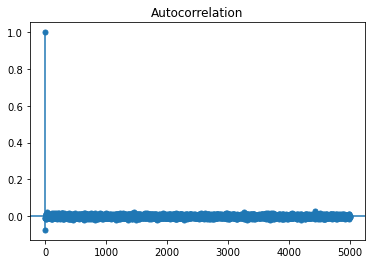

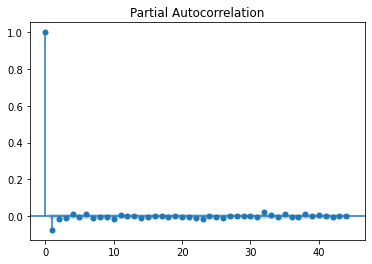

In [8]:
plot_acf(X_train[:, 0, target_column], lags=5000)  # ACF
# plt.ylim(0, 0.2)
plt.show()
plot_pacf(X_train[:, 0, target_column])
# plt.ylim(-0.1, 0.1)
plt.show()

In [9]:
g = grangercausalitytests(X_train[:, 0, target_column:(target_column+2)], maxlag =10, verbose = 0)
g[1]

({'ssr_ftest': (21.330088294145494, 3.886896483045375e-06, 23204.0, 1),
  'ssr_chi2test': (21.332846019748082, 3.860597665401616e-06, 1),
  'lrtest': (21.323047001787927, 3.880381653225e-06, 1),
  'params_ftest': (21.33008829414203, 3.886896483048199e-06, 23204.0, 1.0)},
  array([[0., 1., 0.]])])

In [10]:
print(f"ndiffs: {pmd.arima.ndiffs(X_train[:, 0, target_column])}")
print(f"nsdiffs: {pmd.arima.nsdiffs(X_train[:, 0, target_column], m=2)}")

ndiffs: 0
nsdiffs: 0


In [11]:
# see https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
arima = pmd.auto_arima(
    X_train[:, 0, target_column],
    d=pmd.arima.ndiffs(X_train[:, 0, target_column]),
    start_p=1,
    max_p=20,
    start_q=0,
    max_q=20,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    test='adf',
    trace=True
)
arima

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-305423.526, Time=2.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-305296.985, Time=3.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-305426.537, Time=10.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-305298.221, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-305426.540, Time=6.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-305421.606, Time=16.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-305420.529, Time=7.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-305426.405, Time=9.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-305425.921, Time=4.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-305427.652, Time=3.44 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-305427.640, Time=0.80 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-305424.639, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-305422.809, Time=2.81 s

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
mod = sm.tsa.arima.ARIMA(
    X_train[:,0, target_column],
#     exog=X_train[:,0, [i for i in range(min(10, X_train.shape[2])) if i !=3]],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
model_train = mod.fit()
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                23208
Model:                 ARIMA(1, 0, 1)   Log Likelihood              152717.285
Date:                Fri, 26 Nov 2021   AIC                        -305426.571
Time:                        12:52:03   BIC                        -305394.362
Sample:                             0   HQIC                       -305416.109
                              - 23208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.918e-06   2.07e-06      0.928      0.353   -2.13e-06    5.97e-06
ar.L1          0.1251      0.001    100.797      0.000       0.123       0.128
ma.L1         -0.2006      0.001   -160.850      0.0

In [13]:
from sklearn.metrics import r2_score
r2_score(X_train[:,0, target_column], model_train.predict())

0.005739742698898653

In [14]:
y_train_pred = model_train.predict()

In [15]:
m_min = np.min([y_train.min(), y_train_pred[y_train_pred != 0].min()])
m_max = np.max([y_train.max(), y_train_pred.max()])

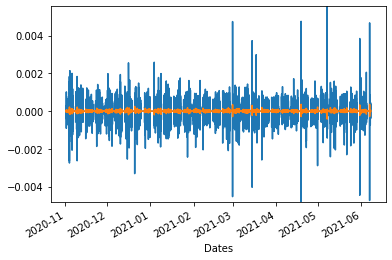

In [16]:
pd.Series(
    data=y_train[:, 0],
    index=index_train[-y_train_pred.shape[0]:],
).plot()
pd.Series(
    data=y_train_pred,
    index=index_train[-y_train_pred.shape[0]:],
).plot()
plt.ylim(m_min, m_max)
plt.show()

In [17]:
y_pred_error = pd.Series(
    data=y_train_pred.flatten() - y_train.flatten(),
    index=index_train[-y_train_pred.shape[0]:],
).iloc[1:]

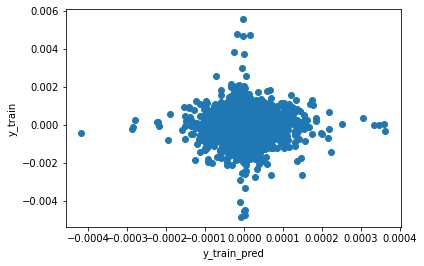

Text(0.5, 1.0, 'QQ-lot for y_train_pred - y_train')

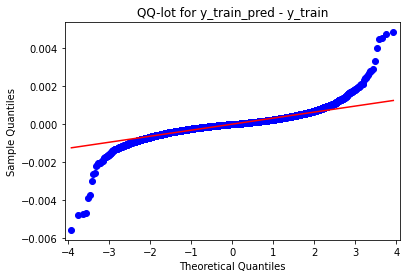

In [18]:
# y_pred_error.plot()
# plt.show()
plt.scatter(y_train_pred[1:], y_train[1:])
plt.xlabel('y_train_pred')
plt.ylabel('y_train')
plt.show()
import statsmodels.api as smi
smi.qqplot(y_pred_error[1:], line = "r")
plt.title('QQ-lot for y_train_pred - y_train')
# pylab.show()

In [19]:
y = y_train
y_pred = y_train_pred
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')


mse: 1.138427791607519e-07
mae: 0.00021998170986407836
mape: 428.40132952740066
mde: 0.24749549334215837


In [21]:
mod2 = sm.tsa.arima.ARIMA(
    X_test[:, 0, target_column],
#     exog=X_test[:,0, [i for i in range(min(10, X_test.shape[2])) if i !=3]],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
with mod2.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_test = mod2.fit()
print(model_test.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2899
Model:                 ARIMA(1, 0, 1)   Log Likelihood               19339.574
Date:                Fri, 26 Nov 2021   AIC                         -38679.148
Time:                        12:52:53   BIC                         -38679.148
Sample:                             0   HQIC                        -38679.148
                               - 2899                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const (fixed)   1.918e-06        nan        nan        nan         nan         nan
ar.L1 (fixed)      0.1251        nan        nan        nan         nan         nan
ma.L1 (fixed)     -0.2006        nan

Get model for test data.

(1.4100746e-07, <AxesSubplot:>)

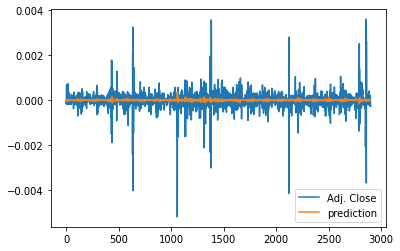

In [22]:
actual_pred_plot(model_test.predict().reshape([-1,1]), X_test[:, 0, 3:4])

<AxesSubplot:xlabel='Dates'>

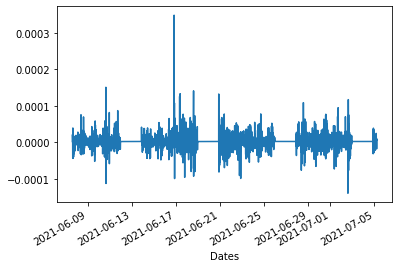

In [23]:
y_test_pred = pd.Series(
    data=model_test.predict(),
    index=index_test[-model_test.predict().shape[0]:],
)
y_test_pred.plot()

In [24]:
y = y_test
y_pred = y_test_pred.values
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

(2899, 1)
(2899,)
mse: 9.257088537009565e-08
mae: 0.00019796012767338422
mape: 333.3034043902572
mde: 0.24414495897077593


In [25]:
y_pred.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'